May: **Research Questions 2.2** (Ideal and Real)

# Which of the three upwelling mechanisms (time dependence, advection, convergence of isobaths, coastal trapped wave) provides the strongest contribution to upwelling in Mackenzie Canyon?

At what depths does maximum upwelling occur?

(48 hrs) 46 min 

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

/home/imachuca/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def get_max_displacement(dirname, fname, meshmaskname, dep_ind, time_s, time_f, vosaline_ref_profile):

    start_time = datetime.now() 

    vosaline, sozotaux, deptht, tmask = upwelling_functions.get_vars_salt(dirname, fname, meshmaskname, 
                                                                            dep_ind, time_s, time_f, None)
    max_vosaline = np.full([vosaline.shape[0]], np.nan)
    min_vosaline = np.full([vosaline.shape[0]], np.nan)
    
    for t in range(vosaline.shape[0]):
        max_vosaline[t] = np.nanmax(vosaline[t, :, :])
        min_vosaline[t] = np.nanmin(vosaline[t, :, :])
        
    max_depth_ind = upwelling_functions.get_daily_depth_ind(max_vosaline, vosaline_ref_profile)
    max_depth_m, max_depth_upwelled = upwelling_functions.get_daily_depth_m(deptht, dep_ind, max_depth_ind, tmask)
    
    min_depth_ind = upwelling_functions.get_daily_depth_ind(min_vosaline, vosaline_ref_profile)
    min_depth_m, min_depth_upwelled = upwelling_functions.get_daily_depth_m(deptht, dep_ind, min_depth_ind, tmask)

    time_elapsed = datetime.now() - start_time 
    print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))
        
    return max_depth_upwelled, min_depth_upwelled, sozotaux, deptht, tmask

In [3]:
def plot_axes(axes, n, max_depth_upwelled, min_depth_upwelled, tmask, deptht, dep_ind, time_s, time_f):
    xs = np.arange(tmask.shape[-1])
    ys = np.arange(tmask.shape[-2])
    ts = np.arange(time_s+1, time_f+1)
    
    cmap = LinearSegmentedColormap.from_list('mycmap', ['wheat', 'white'])

    p = axes[n, 0].pcolormesh(xs, ys, tmask, cmap=cmap)
    axes[n, 0].set_xlim([0, xs[-1]])
    axes[n, 0].set_ylim([0, ys[-1]])
    axes[n, 0].set_title('depth ' + str(int(round(int(deptht[dep_ind])))) +' m', fontsize=20)
    axes[n, 0].set_aspect(aspect='equal')
    
    axes[n, 1].plot(ts, min_depth_upwelled, c='steelblue', lw=2, label='downwelling')
    axes[n, 1].plot(ts, max_depth_upwelled, c='tomato', lw=2, label='upwelling')
    axes[n, 1].axhline(0, c='k', lw=2, linestyle='--')
    axes[n, 1].xaxis.set_ticks(np.arange(time_s+1, time_f+1, 24))
    axes[n, 1].set_ylim([-50, 200])
    axes[n, 1].set_xlim([0, ts[-1]])
    axes[n, 1].legend(ncol=2, loc=1, fontsize=15)
    axes[n, 1].grid()
    
    return

In [4]:
def execute_functions(dirname, fname, meshmaskname, dep_ind, time_s, time_f, vosaline_ref_profile, kind, case):

    fig, axes = plt.subplots(4, 2, figsize=(20, 12), gridspec_kw={"width_ratios":[1, 3]})
    fig.tight_layout(w_pad=0.5, h_pad=2)
    
    ts = np.arange(time_s+1, time_f+1)
    
    max_all = np.full([len(ts),4], np.nan)
    min_all = np.full([len(ts),4], np.nan)
    
    max_all[:, 0] = ts
    min_all[:, 0] = ts

    for n, dep_ind in zip(np.arange(1, len(dep_inds)+1), dep_inds):
        max_depth_upwelled, min_depth_upwelled, sozotaux, deptht, tmask = get_max_displacement(dirname, fname, meshmaskname, dep_ind, time_s, time_f, vosaline_ref_profile)
        plot_axes(axes, n, max_depth_upwelled, min_depth_upwelled, tmask, deptht, dep_ind, time_s, time_f)
        max_all[:, n] = max_depth_upwelled
        min_all[:, n] = min_depth_upwelled

    axes[0, 0].remove()
    axes[0, 1].plot(ts, sozotaux, c='k', lw=2)
    axes[0, 1].xaxis.set_ticks(np.arange(time_s+1, time_f+1, 23))
    axes[0, 1].set_title('Wind Stress [$Nm^{-2}$]', fontsize=20)
    axes[0, 1].xaxis.set_ticks(np.arange(time_s+1, time_f+1, 24))
    axes[0, 1].set_xlim([0, ts[-1]])
    axes[0, 1].grid()
    plt.subplots_adjust(top=0.90)
    fig.suptitle(kind+' - '+case+': '+' hourly maximum vertical displacement [m]', fontsize=30)

    #fig.savefig('../writing_images/displaced_max_time_series_'+kind+'_'+case+'.png', dpi=100, bbox_inches='tight')
    
    return max_all, min_all

# Constants

In [5]:
vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
vosaline_ref_profile = vosaline_ref[0, :, 0, 0]

fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'

time_s = 0 # python count
time_f = 10*24 # python count
dep_inds = [1, 9, 16]

# Ideal

Time elapsed (hh:mm:ss.ms) 0:00:15.118296
Time elapsed (hh:mm:ss.ms) 0:00:14.838204
Time elapsed (hh:mm:ss.ms) 0:00:14.959672


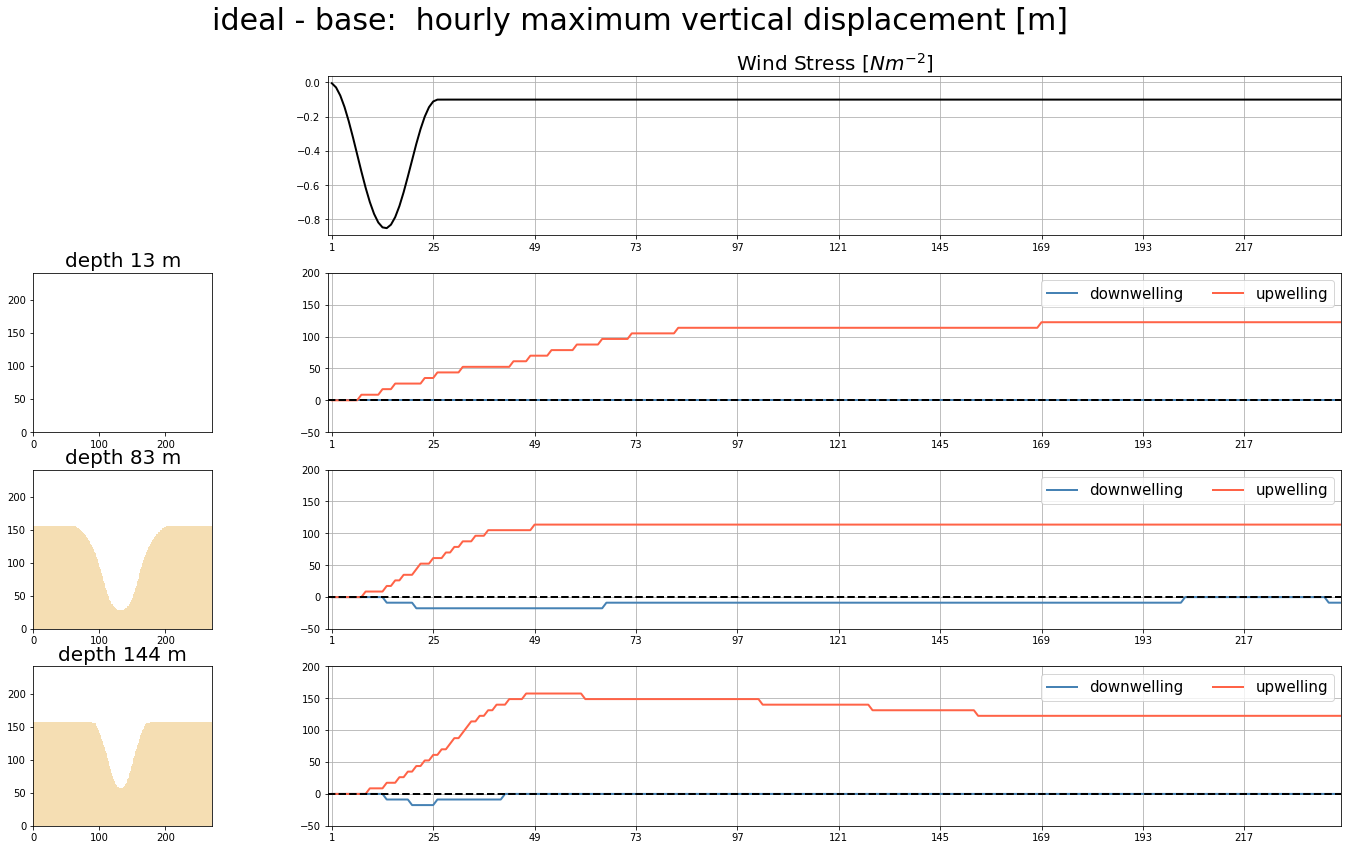

In [6]:
kind = 'ideal'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
max_all, min_all = execute_functions(dirname, fname, meshmaskname, dep_inds, time_s, time_f, vosaline_ref_profile, kind, case)

In [8]:
min_all

array([[  1.  ,   0.  ,   0.  ,   0.  ],
       [  2.  ,   0.  ,   0.  ,   0.  ],
       [  3.  ,   0.  ,   0.  ,   0.  ],
       [  4.  ,   0.  ,   0.  ,   0.  ],
       [  5.  ,   0.  ,   0.  ,   0.  ],
       [  6.  ,   0.  ,   0.  ,   0.  ],
       [  7.  ,   0.  ,   0.  ,   0.  ],
       [  8.  ,   0.  ,   0.  ,   0.  ],
       [  9.  ,   0.  ,   0.  ,   0.  ],
       [ 10.  ,   0.  ,   0.  ,   0.  ],
       [ 11.  ,   0.  ,   0.  ,   0.  ],
       [ 12.  ,   0.  ,   0.  ,   0.  ],
       [ 13.  ,   0.  ,   0.  ,   0.  ],
       [ 14.  ,   0.  ,  -8.75,  -8.75],
       [ 15.  ,   0.  ,  -8.75,  -8.75],
       [ 16.  ,   0.  ,  -8.75,  -8.75],
       [ 17.  ,   0.  ,  -8.75,  -8.75],
       [ 18.  ,   0.  ,  -8.75,  -8.75],
       [ 19.  ,   0.  ,  -8.75,  -8.75],
       [ 20.  ,   0.  ,  -8.75, -17.5 ],
       [ 21.  ,   0.  , -17.5 , -17.5 ],
       [ 22.  ,   0.  , -17.5 , -17.5 ],
       [ 23.  ,   0.  , -17.5 , -17.5 ],
       [ 24.  ,   0.  , -17.5 , -17.5 ],
       [ 25.  , 

# Real

Time elapsed (hh:mm:ss.ms) 0:00:15.263137
Time elapsed (hh:mm:ss.ms) 0:00:15.448644
Time elapsed (hh:mm:ss.ms) 0:00:15.480411


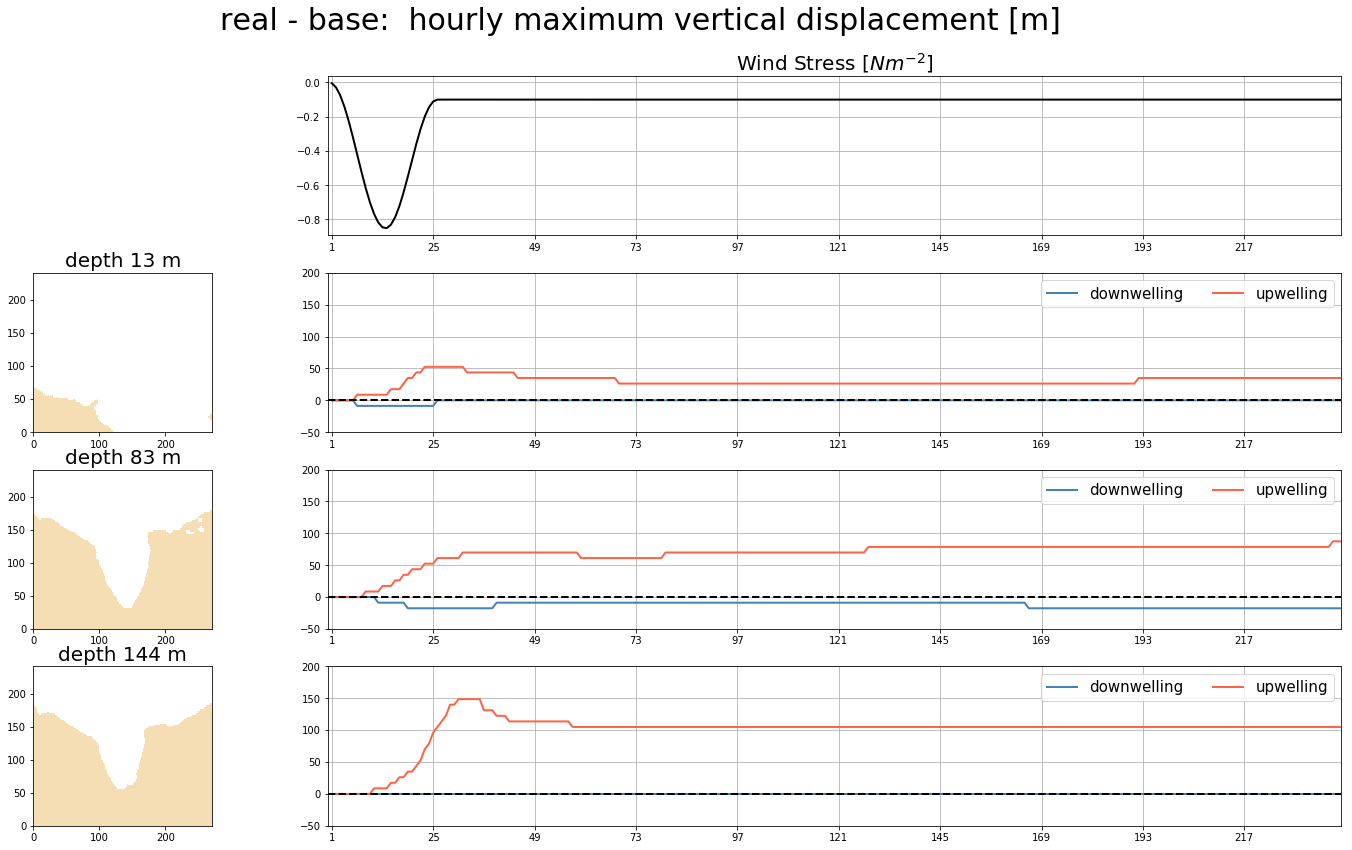

In [10]:
kind = 'real'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
max_all, min_all = execute_functions(dirname, fname, meshmaskname, dep_inds, time_s, time_f, vosaline_ref_profile, kind, case)

In [12]:
min_all

array([[  1.  ,   0.  ,   0.  ,   0.  ],
       [  2.  ,   0.  ,   0.  ,   0.  ],
       [  3.  ,   0.  ,   0.  ,   0.  ],
       [  4.  ,   0.  ,   0.  ,   0.  ],
       [  5.  ,   0.  ,   0.  ,   0.  ],
       [  6.  ,   0.  ,   0.  ,   0.  ],
       [  7.  ,  -8.75,   0.  ,   0.  ],
       [  8.  ,  -8.75,   0.  ,   0.  ],
       [  9.  ,  -8.75,   0.  ,   0.  ],
       [ 10.  ,  -8.75,   0.  ,   0.  ],
       [ 11.  ,  -8.75,   0.  ,   0.  ],
       [ 12.  ,  -8.75,  -8.75,   0.  ],
       [ 13.  ,  -8.75,  -8.75,   0.  ],
       [ 14.  ,  -8.75,  -8.75,   0.  ],
       [ 15.  ,  -8.75,  -8.75,   0.  ],
       [ 16.  ,  -8.75,  -8.75,   0.  ],
       [ 17.  ,  -8.75,  -8.75,   0.  ],
       [ 18.  ,  -8.75,  -8.75,   0.  ],
       [ 19.  ,  -8.75, -17.5 ,   0.  ],
       [ 20.  ,  -8.75, -17.5 ,   0.  ],
       [ 21.  ,  -8.75, -17.5 ,   0.  ],
       [ 22.  ,  -8.75, -17.5 ,   0.  ],
       [ 23.  ,  -8.75, -17.5 ,   0.  ],
       [ 24.  ,  -8.75, -17.5 ,   0.  ],
       [ 25.  , 